<a href="https://colab.research.google.com/github/AkarisDimitry/navier_stokes_2d/blob/main/navier_stokes_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Code to solve the Navier-Stokes equations in 2D

In this code, we use the finite difference method to solve the 2D Navier-Stokes equations for incompressible flow. The Navier-Stokes equations describe fluid motion and are composed of conservation of mass and momentum.

The finite difference method allows us to discretize the domain and the equations to obtain an approximate numerical solution. Here, we use a discretization on a regular mesh in two dimensions.

The coupled Navier-Stokes equations are solved using a projection approach, where a provisional velocity is first calculated and then corrected using a Poisson equation for pressure.

The discretized system of equations is solved iteratively in time, updating the velocities and pressure at each step. In the end, we get the updated velocity and pressure fields.

The 2D Navier-Stokes equations can be written as:

\begin{align}
\frac{{\partial u}}{{\partial t}} + u \frac{{\partial u}}{{\partial x}} + v \frac{{\partial u}}{{\partial y}} = \nu \left( \frac{{\partial^2 u}}{{\partial x^2}} + \frac{{\partial^2 u}}{{\partial y^2}} \right)
\end{align}

\begin{align}
\frac{{\partial v}}{{\partial t}} + u \frac{{\partial v}}{{\partial x}} + v \frac{{\partial v}}{{\partial y}} = \nu \left( \frac{{\partial^2 v}}{{\partial x^2}} + \frac{{\partial^2 v}}{{\partial y^2}} \right)
\end{align}

\begin{align}
\frac{{\partial u}}{{\partial x}} + \frac{{\partial v}}{{\partial y}} = 0
\end{align}

Where $\left( u \right)$ and $\left( v \right)$ are the components of velocity in the x and y directions, respectively. \( $\nu$ \) is the viscosity of the fluid.

Let's solve the Navier-Stokes equations and see the results!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from numba import jit, float64, int64
from numba.types import Tuple


# 2. Code implementation

Here is the Python code that solves the Navier-Stokes equations using the finite difference method...

The `navier_stokes_2d` function solves the 2D incompressible Navier-Stokes equations using the finite difference method. The function takes the following parameters:


* u (numpy.ndarray): Velocity field in the x direction.
* v (numpy.ndarray): Velocity field in the y direction.
* p (numpy.ndarray): Pressure field.
* rho (float): Fluid density.
* nu (float): Fluid viscosity.
* dx (float): Step size in the x direction.
* dy (float): Step size in the y direction.
* dt (float): Step size in time.
* nx (int): Number of points in the x direction.
* ny (int): Number of points in the y direction.
* nt (int): Number of time steps.

The function returns the updated velocity fields \texttt{u} and \texttt{v}, as well as the updated pressure field \texttt{p}.

The implementation of the function involves the following steps:

1. Velocity predictions:
   \begin{align}
   u^* = u^n - \left(u^n \frac{\Delta t}{\Delta x} (u^n - u^n_{i-1,j}) - v^n \frac{\Delta t}{\Delta y} (u^n - u^n_{i,j-1}) + \nu \frac{\Delta t}{\Delta x^2} (u^n_{i+1,j} - 2u^n_{i,j} + u^n_{i-1,j}) + \nu \frac{\Delta t}{\Delta y^2} (u^n_{i,j+1} - 2u^n_{i,j} + u^n_{i,j-1})\right)
   \end{align}
   \begin{align}
   v^* = v^n - \left(u^n \frac{\Delta t}{\Delta x} (v^n - v^n_{i-1,j}) - v^n \frac{\Delta t}{\Delta y} (v^n - v^n_{i,j-1}) + \nu \frac{\Delta t}{\Delta x^2} (v^n_{i+1,j} - 2v^n_{i,j} + v^n_{i-1,j}) + \nu \frac{\Delta t}{\Delta y^2} (v^n_{i,j+1} - 2v^n_{i,j} + v^n_{i,j-1})\right)
   \end{align}

2. Solving the Poisson equation for pressure:
   \begin{align}
   p^{n+1}_{i,j} = \frac{1}{2(\Delta x^2 + \Delta y^2)} \left((p^n_{i+1,j} + p^n_{i-1,j}) \Delta y^2 + (p^n_{i,j+1} + p^n_{i,j-1}) \Delta x^2 - \frac{\Delta x^2 \Delta y^2}{2(\Delta x^2 + \Delta y^2)} \left(\frac{u^*_{i+1,j} - u^*_{i-1,j}}{2\Delta x} + \frac{v^*_{i,j+1} - v^*_{i,j-1}}{2\Delta y}\right)\right)
   \end{align}

3. Velocity corrections:
   \begin{align}
   u^{n+1}_{i,j} = u^*_{i,j} - \frac{\Delta t}{\Delta x} (p^{n+1}_{i+1,j} - p^{n+1}_{i-1,j})
   \end{align}
   \begin{align}
   v^{n+1}_{i,j} = v^*_{i,j} - \frac{\Delta t}{\Delta y} (p^{n+1}_{i,j+1} - p^{n+1}_{i,j-1})
   \end{align}

In [3]:

def navier_stokes_2d(u, v, p, rho, nu, dx, dy, dt, nx, ny, nt):
    """
    Solve the Navier-Stokes equations for an incompressible 2D flow using the finite difference method.

    Parameters:
    u (numpy.ndarray): velocity field in the x direction.
    v (numpy.ndarray): velocity field in the y direction.
    p (numpy.ndarray): pressure field.
    rho (float): fluid density.
    nu (float): fluid viscosity.
    dx (float): step size in the x direction.
    dy (float): step size in the y direction.
    dt (float): step size in time.
    nx (int): number of points in the x direction.
    ny (int): number of points in the y direction.
    nt (int): number of time steps.

    Returns:
    u (numpy.ndarray): updated velocity field in the x direction.
    v (numpy.ndarray): updated velocity field in the y direction.
    p (numpy.ndarray): updated pressure field.
    """
    
    # Velocity predictions
    u_star = u.copy()
    v_star = v.copy()
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()

        # Momentum equations
        u_star[1:-1, 1:-1] = (un[1:-1, 1:-1] - 
                               dt / dx * un[1:-1, 1:-1] * (un[1:-1, 1:-1] - un[:-2, 1:-1]) -
                               dt / dy * vn[1:-1, 1:-1] * (un[1:-1, 1:-1] - un[1:-1, :-2]) +
                               nu * dt / dx**2 * (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[:-2, 1:-1]) +
                               nu * dt / dy**2 * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, :-2]))

        v_star[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                               dt / dx * un[1:-1, 1:-1] * (vn[1:-1, 1:-1] - vn[:-2, 1:-1]) -
                               dt / dy * vn[1:-1, 1:-1] * (vn[1:-1, 1:-1] - vn[1:-1, :-2]) +
                               nu * dt / dx**2 * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[:-2, 1:-1]) +
                               nu * dt / dy**2 * (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, :-2]))

        # Solving the Poisson equation for pressure
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[2:, 1:-1] + pn[:-2, 1:-1]) * dy**2 + 
                          (pn[1:-1, 2:] + pn[1:-1, :-2]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          ((u_star[2:, 1:-1] - u_star[:-2, 1:-1]) / (2 * dx) +
                           (v_star[1:-1, 2:] - v_star[1:-1, :-2]) / (2 * dy)))

        # Velocity corrections
        u[1:-1, 1:-1] = u_star[1:-1, 1:-1] - dt / dx * (p[2:, 1:-1] - p[:-2, 1:-1])
        v[1:-1, 1:-1] = v_star[1:-1, 1:-1] - dt / dy * (p[1:-1, 2:] - p[1:-1, :-2])

    return u, v, p


3. Initialization and variable representation

To initialize the variables and perform the simulation, the following variables need to be defined:

* `u` (numpy.ndarray): The velocity field in the x direction. This represents the fluid velocity component in the x direction at each grid point.
* `v` (numpy.ndarray): The velocity field in the y direction. This represents the fluid velocity component in the y direction at each grid point.
* `p` (numpy.ndarray): The pressure field. This represents the pressure at each grid point.
* `rho` (float): The fluid density. This parameter determines the mass per unit volume of the fluid.
* `nu` (float): The fluid viscosity. This parameter determines the resistance to flow within the fluid.
* `dx` (float): The step size in the x direction. This represents the spacing between adjacent grid points in the x direction.
* `dy` (float): The step size in the y direction. This represents the spacing between adjacent grid points in the y direction.
* `dt` (float): The step size in time. This determines the time interval between each iteration of the simulation.
* `nx` (int): The number of points in the x direction. This represents the total number of grid points in the x direction.
* `ny` (int): The number of points in the y direction. This represents the total number of grid points in the y direction.
* `nt` (int): The number of time steps. This determines the total number of iterations for the simulation.

These variables should be initialized with appropriate values before calling the `navier_stokes_2d` function to ensure a proper simulation of the fluid flow.


In [4]:

Nx, Ny = 100, 100  # number of grid points in x and y direction
T = 75  # total time

u = np.zeros((Nx, Ny))
v = np.zeros((Nx, Ny))
p = np.zeros((Nx, Ny))


# Definición de las dimensiones

sigma = 15.0  # Desviación estándar
mu_x = Nx / 2  # Media en el eje x
mu_y = Ny / 2  # Media en el eje y
x = np.linspace(0, Nx, Nx) # Creación de los arrays 1D para x e y
y = np.linspace(0, Ny, Ny) # Creación de los arrays 1D para x e y
X, Y = np.meshgrid(x, y)

u[0, 40:60] = 2
v[40:60, 0] = 2
u -= np.exp(-0.5 * ((X - mu_x)**2 + (Y - mu_y)**2) / sigma**2) * 1.5
v -= np.exp(-0.5 * ((X - mu_x)**2 + (Y - mu_y)**2) / sigma**2) * 1.5

rho =  0.1 
nu = 0.01
dx = 0.01
dy = 0.01
dt = 0.0001

# number of grid points in x and y direction
nx = Nx
ny = Ny


4. Visualization

To visualize the results of the Navier-Stokes simulation, we can create a plot of the velocity magnitude at each grid point in the domain. This will give us a visual representation of the flow patterns.

To do this, we can use the `imshow` function from the `matplotlib.pyplot` module. The `imshow` function takes a 2D array as input and creates a color plot where the color intensity represents the magnitude of the values in the array.

In our case, we can calculate the magnitude of the velocity at each grid point using the formula:

  \begin{align}
  
  $magnitude = \sqrt{u^2 + v^2}$

  \end{aling}

where \text{{u}} and \text{{v}} are the velocity fields in the x and y directions, respectively.

We can then create a figure and an axis using the `subplots` function from `matplotlib.pyplot`, and use the `imshow` function to create the color plot. Finally, we can display the plot using the `show` function.

Here's an example code snippet:

```python
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Create the color plot using imshow
img = ax.imshow(magnitude, cmap='viridis')

# Display the plot
plt.show()

0
0
0
0
1
2
3
4
5
6
7
8
9


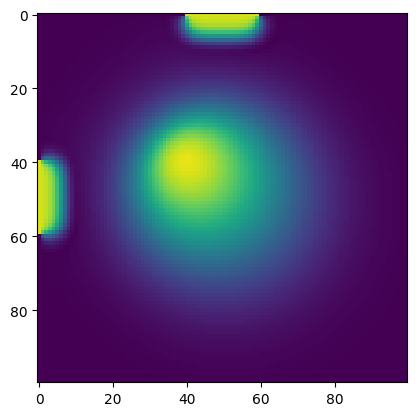

In [5]:

# simulate over T time steps
u, v, p = navier_stokes_2d(u, v, p, rho, nu, dx, dy, dt, nx, ny, 1)

fig, ax = plt.subplots()
img = ax.imshow(np.sqrt(u**2 + v**2), cmap='viridis')

# Function to update the image for each time step
def update(i):
    global u, v, p
    u, v, p = navier_stokes_2d(u, v, p, rho, nu, dx, dy, dt, nx, ny, 50)
    img.set_data(np.sqrt(u**2 + v**2))
    return img,

# Animation of the solution
ani = animation.FuncAnimation(fig, update, frames=10, blit=True)

# Save the animation as a mp4 file
ani.save('navier_stokes.mp4', writer='ffmpeg')

# Show the plot
plt.show()